In [1]:
import json
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('husl')
%matplotlib inline

In [2]:
with open('../data/geometries.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])
transects = inp['transects']

In [3]:
H_bc = pd.read_csv('../data/boundary_stage.csv', index_col=0)
Q_in = pd.read_csv('../data/flow_input.csv', index_col=0)
t_range = H_bc.index.values

In [4]:
superlink = SuperLink(superlinks, superjunctions, links, junctions, transects, dt=1e-6)    

In [5]:
# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = t_range[0]

# For each time step...
for t_next in t_range[1:]:
    # Compute time difference between steps
    dt = t_next - t_prev
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get net flow input
    Q_in_next = Q_in.loc[t_next].values
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=Q_in_next, dt=dt)
    # Store previous timestamp
    t_prev = t_next
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [6]:
Q = np.vstack(Qs)
H = np.vstack(Hs)
Q_in = np.vstack(Q_ins)
H_bc = np.vstack(H_bcs)
ts = np.asarray(ts)

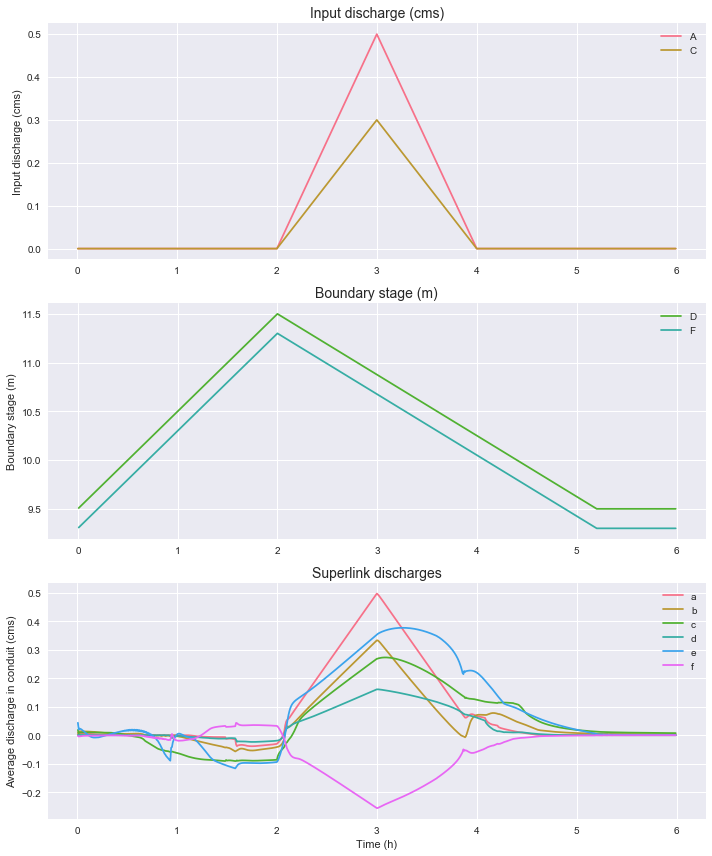

In [7]:
fig, ax = plt.subplots(3, figsize=(10, 12))
ax[0].plot(ts / 3600, Q_in[:,0], label='A')
ax[0].plot(ts / 3600, Q_in[:,2], label='C')
ax[0].set_title('Input discharge (cms)', size=14)
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, H[:,3], label='D')
ax[1].plot(ts / 3600, H[:,5], label='F')
ax[1].set_title('Boundary stage (m)', size=14)
ax[1].set_ylabel('Boundary stage (m)')
ax[1].legend()
ax[2].plot(ts / 3600, Q[:,0], label='a')
ax[2].plot(ts / 3600, Q[:,1], label='b')
ax[2].plot(ts / 3600, Q[:,2], label='c')
ax[2].plot(ts / 3600, Q[:,3], label='d')
ax[2].plot(ts / 3600, Q[:,4], label='e')
ax[2].plot(ts / 3600, Q[:,5], label='f')
ax[2].set_title('Superlink discharges', size=14)
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('Average discharge in conduit (cms)')
ax[2].legend()
plt.tight_layout()